In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import bootstrap

# Giannoulis, this is a test

            Timestamp      Wsp      TI  TI,detrend   MeanDir  MeanTrigDir  \
0 2004-10-01 00:00:00   9.9196  0.0181      0.0145  346.7130     346.7130   
1 2004-10-01 00:20:00   9.5073  0.0145      0.0116  346.9852     346.9852   
2 2004-10-01 00:30:00   9.5274  0.0210      0.0195  346.9152     346.9151   
3 2004-10-01 00:40:00   9.9498  0.0253      0.0195  346.3204     346.3204   
4 2004-10-01 00:50:00  10.2376  0.0151      0.0134  345.4185     345.4185   

   StdDir   MinDir   MaxDir  
0  0.8440  343.893  349.044  
1  0.6518  344.751  348.949  
2  0.7949  343.754  350.588  
3  0.7549  343.971  349.953  
4  0.6362  343.074  348.960  


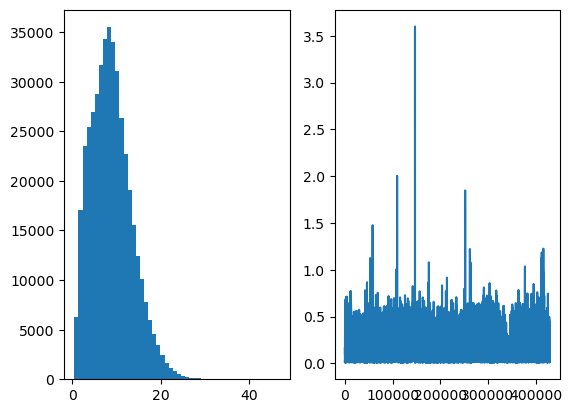

In [2]:
data_path = '../data/'
results_path = '../results/'

# load and print dataset
raw_data = pd.read_csv(data_path + 'HovsoreData_Sonic_100m_2004-2013.csv')
raw_data.head()
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'], format='%Y%m%d%H%M')

filt_idx = ((raw_data["Wsp"] > 60) | (raw_data["Wsp"] < 0.05)) | ((raw_data["TI"] < 0.01) | (raw_data["TI"] > 4))
filtered_data = raw_data[~filt_idx]
filtered_data = filtered_data.dropna(axis=0)
filtered_data = filtered_data.reset_index(drop=True)
print(filtered_data.head(5))

# visualise dataset
# plt.plot(raw_data['Wsp'])
fig, ax = plt.subplots(1,2)
# ax[0].hist(raw_data["Wsp"][raw_data["Wsp"] < 60], 50)
# ax[1].plot(raw_data["TI"]) # outliers can be observed
ax[0].hist(filtered_data["Wsp"], 50)
ax[1].plot(filtered_data["TI"]) # outliers can be observed

plt.show()

# Fit joint distribution to wind speed, turbulence

In [3]:
# compute turbulence from sigmaU = TI * Wsp
filtered_data['sigmaWsp'] = filtered_data["TI"] * filtered_data["Wsp"]
filtered_data.head(3)

# fit weibull to wind speed : maximum likelihood method
Wsp0 = np.asarray(filtered_data["Wsp"])
# Wsp0 = Wsp0[Wsp0 < 60]
print(sum(np.isnan(Wsp0)))

mle_Weib = lambda theta : -np.sum(np.log( stats.weibull_min.pdf(Wsp0, loc=0, scale=theta[0], c=theta[1]) ))
Weibull_params = scipy.optimize.minimize(mle_Weib, [Wsp0.mean(), np.log(Wsp0).std()])
print(Weibull_params)
A_weibull = Weibull_params.x[0]
k_weibull = Weibull_params.x[1]

print("\nWeibull distribution:")
print(f"A:{A_weibull}")
print(f"k:{k_weibull}")

# fitted weibull distribution
Wsp_sort = np.sort(Wsp0)
pdf_weibull = stats.weibull_min.pdf(Wsp_sort, scale=A_weibull, c=k_weibull)

0
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1239279.5737238422
        x: [ 9.983e+00  2.033e+00]
      nit: 10
      jac: [ 0.000e+00  0.000e+00]
 hess_inv: [[ 1.294e-04  4.971e-05]
            [ 4.971e-05  2.598e-05]]
     nfev: 42
     njev: 14

Weibull distribution:
A:9.9834258809259
k:2.032556323671337


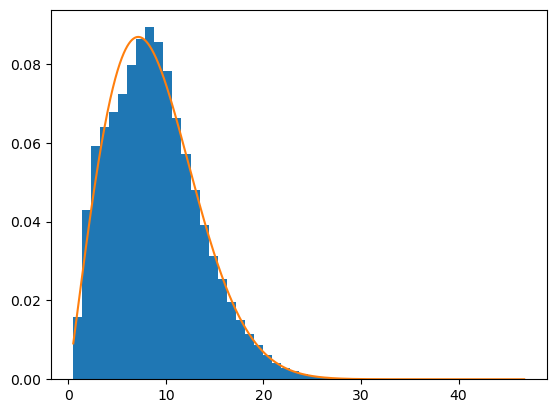

In [4]:
# Visualise fitted distribution
fig, ax = plt.subplots(1)
ax.hist(Wsp0, bins=50, density=True)
ax.plot(Wsp_sort, pdf_weibull)
plt.show()

In [5]:
# Fit conditional distribution to turbulence - bin data
WspBinEdges = np.arange(3.5, 32.5, 1)
WspBinCentres = .5 + WspBinEdges[:-1]

# initialise mean and std of turbulence for each bin
meanSigmaBinned = np.zeros_like(WspBinCentres)
stdSigmaBinned = np.zeros_like(WspBinCentres)

# find mean and std of turbulence (=sigmaU) in each bin
for i,val in enumerate(WspBinCentres):
    WspMask = (filtered_data["Wsp"] > WspBinEdges[i]) & (filtered_data["Wsp"] <= WspBinEdges[i+1])
    meanSigmaBinned[i] = np.mean( filtered_data.loc[WspMask, "sigmaWsp"] )
    stdSigmaBinned[i] = np.std( filtered_data.loc[WspMask, "sigmaWsp"] )
    
meanSigmaBinned = meanSigmaBinned[~np.isnan(meanSigmaBinned)]   
stdSigmaBinned = stdSigmaBinned[~np.isnan(meanSigmaBinned)]   
# print(len(WspBinEdges))
# print(enumerate(WspBinCentres))
# print(len(meanSigmaBinned))
# print(len(meanSigmaBinned))

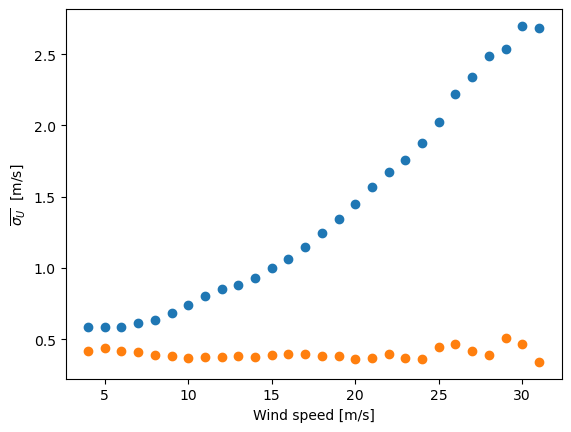

In [6]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r"$\overline{\sigma_U}$  [m/s]")
plt.show()

In [7]:
pMu0 = np.polyfit(WspBinCentres, meanSigmaBinned,0)
pMu1 = np.polyfit(WspBinCentres, meanSigmaBinned,1)
pMu2 = np.polyfit(WspBinCentres, meanSigmaBinned,2)
pMsu0 = np.polyfit(WspBinCentres, stdSigmaBinned,0)

poly0 = np.poly1d(pMu0)
poly1 = np.poly1d(pMu1)
poly2 = np.poly1d(pMu2)
poly3 = np.poly1d(pMsu0)

SigmaSigmaRef = np.mean(stdSigmaBinned)
        
MuSigmaFunc = lambda u: poly2(u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef * np.ones(u.shape)


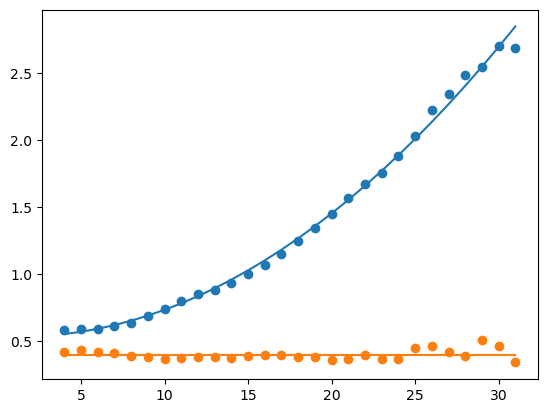

In [8]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
# plt.plot(WspBinCentres, poly0(WspBinCentres))
# plt.plot(WspBinCentres, poly1(WspBinCentres))
plt.plot(WspBinCentres, poly2(WspBinCentres))
plt.plot(WspBinCentres, poly3(WspBinCentres))
plt.show()

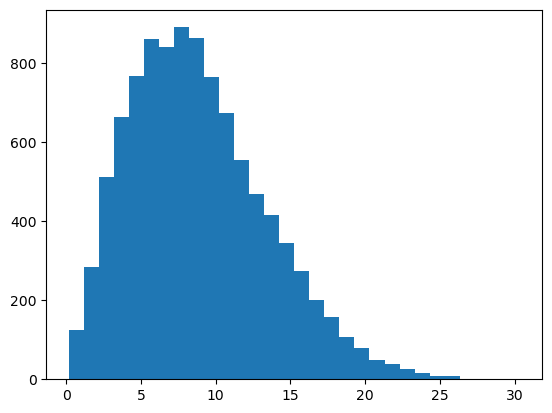

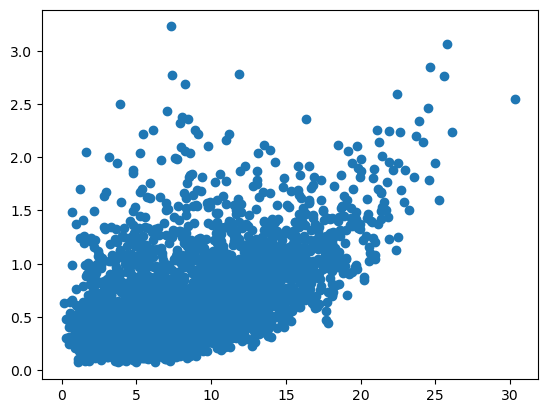

In [9]:
# Monte Carlo 
n = 10000

# Wind speed random sample
Urand = stats.weibull_min.ppf(np.random.randn(n), scale=A_weibull, c=k_weibull)
Urand = stats.weibull_min.rvs(scale=A_weibull, c=k_weibull, size=n)

# Turbulence random sample
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y
# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

MuSigmaU = MuSigmaFunc(Urand)
SigmaSigmaU = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.randn(n), mu=MuSigmaU, sigma=SigmaSigmaU)
# SigmaSigmaUrand = stats.lognorm.ppf(np.random.randn(n), s=SigmaSigmaU)

plt.hist(Urand, 30)
plt.show()
plt.scatter(Urand, SigmaUrand)
plt.show()

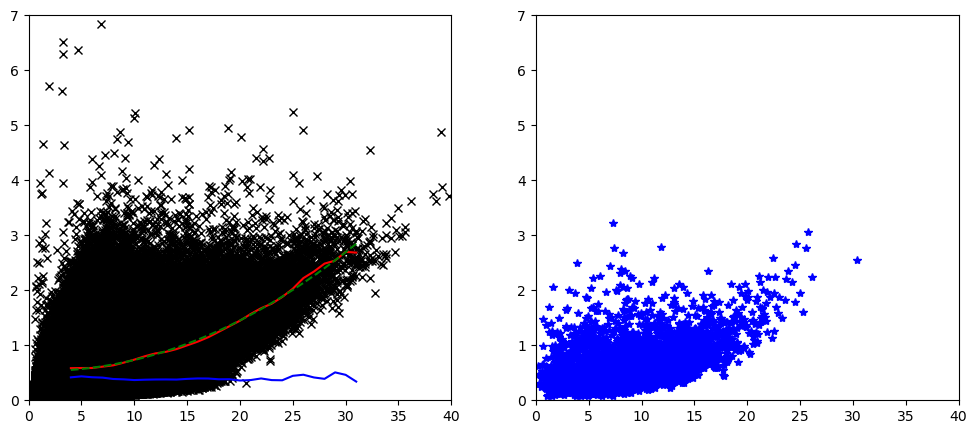

In [10]:
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(filtered_data['Wsp'],filtered_data['sigmaWsp'],'xk')
ax[0].plot(WspBinCentres,meanSigmaBinned,'-r')
ax[0].plot(WspBinCentres,stdSigmaBinned,'-b')
ax[0].plot(WspBinCentres,MuSigmaFunc(WspBinCentres),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

# Task 2

In [11]:
def print_loading_bar(iteration, total, bar_length=100):
    progress = (iteration / total)
    arrow = '=' * int(round(progress * bar_length) - 1)
    spaces = ' ' * (bar_length - len(arrow))

    print(f'\r[{arrow + spaces}] {progress * 100:.0f}%', end='')

In [12]:
# Confidence intervals based on Bootstrapping

yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)
# yearss = [2004]

print(yearss)

alpha = 1-0.98

BootstrapMeans_stacked = np.zeros(1)
Boooooo = np.zeros_like(yearss)

M = 1000

for iyear,year in enumerate(yearss): 
    
#     maybe metavlito M (see this tomorrow)
    
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == year]
    
    M = len(boot2004)
#     print(year, len(boot2004))
    l = 5000
    
#     l = 1000
#     print(l)
    
    BootstrapSample = np.random.choice(boot2004['Wsp'], size = (l, M))
#     BootstrapMeans_temp = np.sort(np.mean(BootstrapSample, axis=1))
    BootstrapMeans_temp = np.mean(BootstrapSample, axis=1)
#     print(len(BootstrapMeans_temp))
    # stack the BootstrapMeans_temp of each year vertically  
    # BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))
    BootstrapMeans_stacked = np.concatenate((BootstrapMeans_stacked, BootstrapMeans_temp), axis=None)
    Boooooo[iyear] = np.mean(BootstrapMeans_temp)
    print_loading_bar(iyear+1,len(yearss))
    

print()
print(Boooooo)
# resort data
BootstrapMeans = np.sort(BootstrapMeans_stacked[1:])
print(np.mean(BootstrapMeans), len(BootstrapMeans))
len_bs = len(BootstrapMeans)

# Determine confidence intervals
Rlow = int(np.around((len_bs+1)*alpha/2))
Rhigh = int(np.around((1-alpha/2)*(len_bs+1)))
print(Rlow, Rhigh)

CIn_B = BootstrapMeans[Rlow]
CIp_B = BootstrapMeans[Rhigh]

print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')

# print(Nbootstrap)
# print(l)
# bootstrapsize 

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
[=================================================================================================== ] 100%
[10  8  8  9  9  8  8  9  9  7]
8.88316390524503 50000
500 49501
Confidence interval based on bootstrapping: [7.609334794728839, 10.139025542558105]


In [72]:
yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)

print(yearss)

alpha = 1-0.95

BootstrapMeans_stacked = np.zeros(1)
Boooooo = np.zeros(yearss.shape)

for iyear,year in enumerate(yearss): 
    
#     maybe metavlito M (see this tomorrow)
    
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == year]
    wsp_mean_temp = boot2004['Wsp'].mean()
    print(wsp_mean_temp)
    print(iyear)
#     M = len(boot2004)
#     print(year, len(boot2004))
#     l = 5000
    
#     l = 1000
#     print(l)
    
#     BootstrapSample = np.random.choice(boot2004['Wsp'], size = (l, M))
#     BootstrapMeans_temp = np.sort(np.mean(BootstrapSample, axis=1))
#     BootstrapMeans_temp = np.mean(BootstrapSample, axis=1)
#     print(len(BootstrapMeans_temp))
    # stack the BootstrapMeans_temp of each year vertically  
    # BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))
#     BootstrapMeans_stacked = np.concatenate((BootstrapMeans_stacked, BootstrapMeans_temp), axis=None)
#     Boooooo[iyear] = np.mean(wsp_mean)
    Boooooo[iyear] = wsp_mean_temp
#     print_loading_bar(iyear+1,len(yearss))
    

print()
print(Boooooo)
# resort data
# BootstrapMeans = np.sort(BootstrapMeans_stacked[1:])
# print(np.mean(BootstrapMeans), len(BootstrapMeans))
# len_bs = len(BootstrapMeans)

# # Determine confidence intervals
# Rlow = int(np.around((len_bs+1)*alpha/2))
# Rhigh = int(np.around((1-alpha/2)*(len_bs+1)))
# print(Rlow, Rhigh)

# CIn_B = BootstrapMeans[Rlow]
# CIp_B = BootstrapMeans[Rhigh]

# print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')


[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
10.081660743420043
0
8.787261217223874
1
8.417612116558418
2
9.502974268871307
3
9.146611058790489
4
8.502559819742608
5
8.288662736326721
6
9.33905285693346
7
9.121512028379277
8
7.6420449895011435
9

[10.08166074  8.78726122  8.41761212  9.50297427  9.14661106  8.50255982
  8.28866274  9.33905286  9.12151203  7.64204499]


In [143]:
Nbootstrap = 100000
BootstrapSize = len(Boooooo) # 8

BootstrapSample = np.random.choice(Boooooo, size = (Nbootstrap,BootstrapSize))

BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))

Rlow = int(np.around(alpha/2*(Nbootstrap+1)))
Rhigh = int(np.around((1-alpha/2)*(Nbootstrap+1)))

print(Rlow,Rhigh)
CIn_B = BootstrapMeans[Rlow]
CIp_B = BootstrapMeans[Rhigh]

print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')
print(CIp_B-CIn_B)

2500 97501
Confidence interval based on bootstrapping: [8.4696328715023, 9.293890991890965]
0.8242581203886648


In [160]:
# from scipy.stats import norm

# dist = norm(loc=2, scale=4)  # our "unknown" distribution
# rng = np.random.default_rng()
# data = dist.rvs(size=100, random_state=rng)
# data = filtered_data['Wsp'][::50].values
# print(data)
# mean_sample = np.mean(data)
# res = bootstrap((data,), np.mean, confidence_level=0.98,
#                 random_state=rng)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=25)
# ax.set_title('Bootstrap Distribution')
# ax.set_xlabel('statistic value')
# ax.set_ylabel('frequency')
# plt.show()

# x = np.linspace(5, 10, 1000)
# pdf = norm.pdf(x, loc=mean_sample, scale=res.standard_error)
# fig, ax = plt.subplots()
# ax.hist(res.bootstrap_distribution, bins=50, density=True)
# ax.plot(x, pdf)
# ax.set_title('Normal Approximation of the Bootstrap Distribution')
# ax.set_xlim(8.6,9)
# ax.set_xlabel('statistic value')
# ax.set_ylabel('pdf')
# plt.show()

In [149]:
n = len(Boooooo)

# print(yearss)
# print(len(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)]))
Umean = np.mean(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)])
Ustd = np.std(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year.isin(yearss)])
Umean = np.mean(Boooooo)
Ustd = np.std(Boooooo)
print(Umean)
# print(len(filtered_data['Wsp'][filtered_data['Timestamp'].dt.year == year]))
# print(len(boot2004))


8.882995183574733


In [150]:
# Confidence intervals based on the Normal distribution

CIn_N = Umean + stats.norm.ppf(alpha/2) * Ustd / np.sqrt(n)
CIp_N = Umean + stats.norm.ppf(1 - alpha/2) * Ustd / np.sqrt(n)

print('Confidence interval based on the Normal distribution: [' + str(CIn_N) + ', ' + str(CIp_N) + ']')

Confidence interval based on the Normal distribution: [8.470973117983942, 9.295017249165525]


In [151]:
# Confidence intervals based on the student's t-distribution

CIn_T = Umean + stats.t.ppf(alpha/2, n-1) * Ustd / np.sqrt(n)
CIp_T = Umean - stats.t.ppf(alpha/2, n-1) * Ustd / np.sqrt(n)

print('Confidence interval based on the student''s t-distribution: [' + str(CIn_T) + ', ' + str(CIp_T) + ']')

Confidence interval based on the students t-distribution: [8.407446309087494, 9.358544058061973]


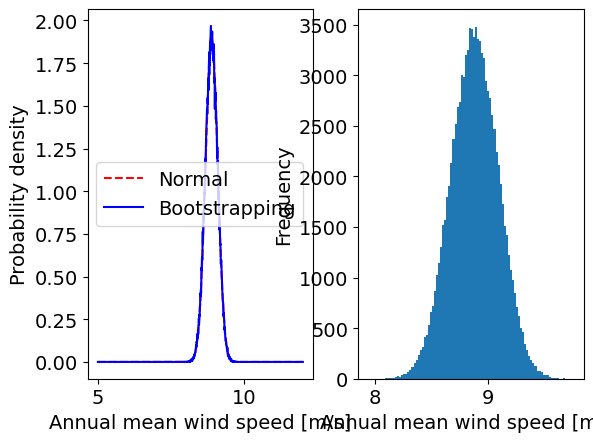

In [162]:
Ubins = np.linspace(5,12,1000)

pdf_N = stats.norm.pdf(Ubins,Umean,Ustd/np.sqrt(n))
dU = Ubins[1]-Ubins[0] # Scaling factor for the t-pdf to make sure we get a valid pdf for every bin spacing
pdf_T = (1/np.sqrt(dU))*stats.t.pdf((Ubins - Umean)/(Ustd/np.sqrt(n)), n - 1)

# Generating an empirical pdf from the bootstrap sample
BootstrapHist = np.histogram(BootstrapMeans,bins = Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

fig1, ax1 = plt.subplots(1,2)
p11 = ax1[0].plot(Ubins,pdf_N,'--r', label = 'Normal')
p12 = ax1[0].plot(Ubins,pdf_B,'-b', label = 'Bootstrapping')
# p13 = ax1[0].plot(Ubins,pdf_T,'-k', label = 'T-dist')
ax1[0].set_xlabel('Annual mean wind speed [m/s]')
ax1[0].set_ylabel('Probability density')
ax1[0].legend()

# p11 = ax1.plot(Ubins,pdf_N,'--r', label = 'Normal')
p22 = ax1[1].hist(BootstrapMeans, 100, label = 'Bootstrapping')
# # p13 = ax1.plot(Ubins,pdf_T,'-k', label = 'T-dist')
ax1[1].set_xlabel('Annual mean wind speed [m/s]')
ax1[1].set_ylabel('Frequency')
# plt.legend()

plt.show()

8.882995183574733
8.883640078946883
8.4696328715023 9.293890991890965
8.470973117983942 9.295017249165525
8.407446309087494 9.358544058061973


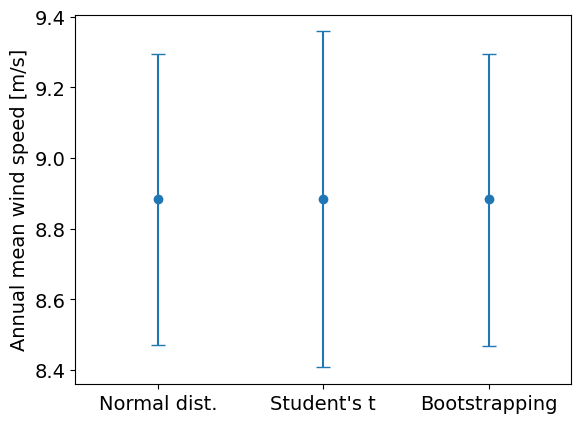

In [153]:
fig0, ax0 = plt.subplots()
print(Umean)
print(np.mean(BootstrapMeans))
print(CIn_B,CIp_B)
print(CIn_N,CIp_N)
print(CIn_T,CIp_T)

lower_error = [Umean-CIn_N, Umean-CIn_T, np.mean(BootstrapMeans)-CIn_B]
upper_error = [CIp_N-Umean, CIp_T-Umean, CIp_B-np.mean(BootstrapMeans)]

asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

ax0.errorbar([1, 2, 3], [Umean, Umean, np.mean(BootstrapMeans)],
             yerr = asymmetric_error,
            linestyle = '',marker = 'o',capsize = 5)
ax0.set_xlim([0.5,3.5])
ax0.set_xticks([1,2,3])
ax0.set_xticklabels(['Normal dist.','Student\'s t','Bootstrapping'])
ax0.set_ylabel('Annual mean wind speed [m/s]')
plt.show()

In [165]:
BootstrapDist.pdf()

SyntaxError: invalid syntax (2062586535.py, line 1)

# Task 3 : Surrogate model

In [20]:
InputData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'InputVariables')
InputData = InputData.set_index('Sample_No', drop = False)
InputData.head()

Sample_No          U    SigmaU     Alpha       MannL  MannGamma  \
Sample_No                                                                    
1                  1   4.000000  0.100000 -0.650000    7.500000   1.000000   
2                  2  10.150758  1.208656 -0.139692   48.470634   1.363636   
3                  3   6.813467  2.261463  0.129071   88.379710   1.727273   
4                  4  14.500000  0.704260  0.332996  122.142857   2.090909   
5                  5   5.356299  1.776301  1.147039  160.357143   2.454545   

           VeerDeltaPhi  
Sample_No                
1            -22.250000  
2             -4.771217  
3             -3.981593  
4              0.162810  
5              2.639008

In [21]:
TargetData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'LoadResults')
TargetData = TargetData.set_index('PointNo', drop = False)
TargetData.head()

PointNo  Tower_top_fore_aft_M_x  Tower_top_side2side_M_y  \
PointNo                                                             
1              1              747.561872               200.666288   
2              2             3556.031457               676.339081   
3              3             4667.540374              1337.390736   
4              4             2468.757942               242.431345   
5              5             3261.845253              1035.420007   

         Tower_base_fore_aft_M_x  Tower_base_side2side_M_y  Yaw_moment_M_z  \
PointNo                                                                      
1                    6708.717789               8861.885588     1229.076579   
2                   16692.647572               6329.099515     6952.985180   
3                   47357.937376              31829.036012    10138.140146   
4                    8130.594535               3871.907737     4216.051060   
5                   36971.924749              26395.063750     6630.640795   

         Main_shaft_torsion_M_z  Blade_root_flapwise_M_x  \
PointNo                                                    
1                     63.457528              4253.317748   
2                   1354.995442             10409.290476   
3                   2804.304402             13755.148891   
4                    250.684887             12307.312889   
5                   2256.349794             13128.763279   

         Blade_root_edgewise_M_y  
PointNo                           
1                   15006.726860  
2                   16289.414152  
3                   16535.154243  
4                   16500.098901  
5                   16207.306417

In [22]:
MergedData = pd.merge(InputData, TargetData, how='inner', on=[InputData['Sample_No'], TargetData['PointNo']])
MergedData

key_0  key_1  Sample_No          U    SigmaU     Alpha       MannL  \
0         1      1          1   4.000000  0.100000 -0.650000    7.500000   
1         2      2          2  10.150758  1.208656 -0.139692   48.470634   
2         3      3          3   6.813467  2.261463  0.129071   88.379710   
3         4      4          4  14.500000  0.704260  0.332996  122.142857   
4         5      5          5   5.356299  1.776301  1.147039  160.357143   
...     ...    ...        ...        ...       ...       ...         ...   
9975   9996   9996       9996  15.991490  2.934493 -0.031461  271.543107   
9976   9997   9997       9997   6.111425  0.948102  0.176589    8.454959   
9977   9998   9998       9998  13.326172  2.043617  0.345013   46.669245   
9978   9999   9999       9999   9.298782  2.830030  0.709374   84.883531   
9979  10000  10000      10000  19.898210  0.684805  0.574862  123.097816   

      MannGamma  VeerDeltaPhi  PointNo  Tower_top_fore_aft_M_x  \
0      1.000000    -22.250000        1              747.561872   
1      1.363636     -4.771217        2             3556.031457   
2      1.727273     -3.981593        3             4667.540374   
3      2.090909      0.162810        4             2468.757942   
4      2.454545      2.639008        5             3261.845253   
...         ...           ...      ...                     ...   
9975   3.760740     14.080259     9996             6564.464434   
9976   4.124377     41.866315     9997             2047.344061   
9977   4.488013     -6.197441     9998             5958.074303   
9978   4.851649     -4.457392     9999             6631.147297   
9979   1.248344     -1.817352    10000             2496.414854   

      Tower_top_side2side_M_y  Tower_base_fore_aft_M_x  \
0                  200.666288              6708.717789   
1                  676.339081             16692.647572   
2                 1337.390736             47357.937376   
3                  242.431345              8130.594535   
4                 1035.420007             36971.924749   
...                       ...                      ...   
9975               858.778565             28091.651088   
9976               385.287048             22144.619831   
9977               646.040924             20715.173212   
9978              1463.861197             42145.162750   
9979               257.615064              8521.878700   

      Tower_base_side2side_M_y  Yaw_moment_M_z  Main_shaft_torsion_M_z  \
0                  8861.885588     1229.076579               63.457528   
1                  6329.099515     6952.985180             1354.995442   
2                 31829.036012    10138.140146             2804.304402   
3                  3871.907737     4216.051060              250.684887   
4                 26395.063750     6630.640795             2256.349794   
...                        ...             ...                     ...   
9975              13608.101268    14513.682848             1147.107370   
9976              16663.888804     3024.747490              676.705869   
9977               7395.479028    11789.005321              740.922800   
9978              21430.048990    15017.124218             3076.452821   
9979               5921.710246     4404.835391              293.419113   

      Blade_root_flapwise_M_x  Blade_root_edgewise_M_y  
0                 4253.317748             15006.726860  
1                10409.290476             16289.414152  
2                13755.148891             16535.154243  
3                12307.312889             16500.098901  
4                13128.763279             16207.306417  
...                       ...                      ...  
9975             21518.552601             16773.394758  
9976              3891.227781             15376.750042  
9977             19334.780023             17384.510924  
9978             24014.999552             18408.246843  
9979             23494.461911             16113.811373  

[9980 rows x 18 columns]

In [23]:
%%timeit -n 10
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])

3.78 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Feature names: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)
print(AllInputData.iloc[:,0].values)
AllInputData

Feature names:  ['U' 'SigmaU' 'Alpha' 'MannL' 'MannGamma' 'VeerDeltaPhi']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']
[ 4.         10.1507576   6.81346652 ... 13.32617204  9.2987816
 19.89821019]


U    SigmaU     Alpha       MannL  MannGamma  VeerDeltaPhi
Sample_No                                                                    
1           4.000000  0.100000 -0.650000    7.500000   1.000000    -22.250000
2          10.150758  1.208656 -0.139692   48.470634   1.363636     -4.771217
3           6.813467  2.261463  0.129071   88.379710   1.727273     -3.981593
4          14.500000  0.704260  0.332996  122.142857   2.090909      0.162810
5           5.356299  1.776301  1.147039  160.357143   2.454545      2.639008
...              ...       ...       ...         ...        ...           ...
9996       15.991490  2.934493 -0.031461  271.543107   3.760740     14.080259
9997        6.111425  0.948102  0.176589    8.454959   4.124377     41.866315
9998       13.326172  2.043617  0.345013   46.669245   4.488013     -6.197441
9999        9.298782  2.830030  0.709374   84.883531   4.851649     -4.457392
10000      19.898210  0.684805  0.574862  123.097816   1.248344     -1.817352

[9980 rows x 6 columns]

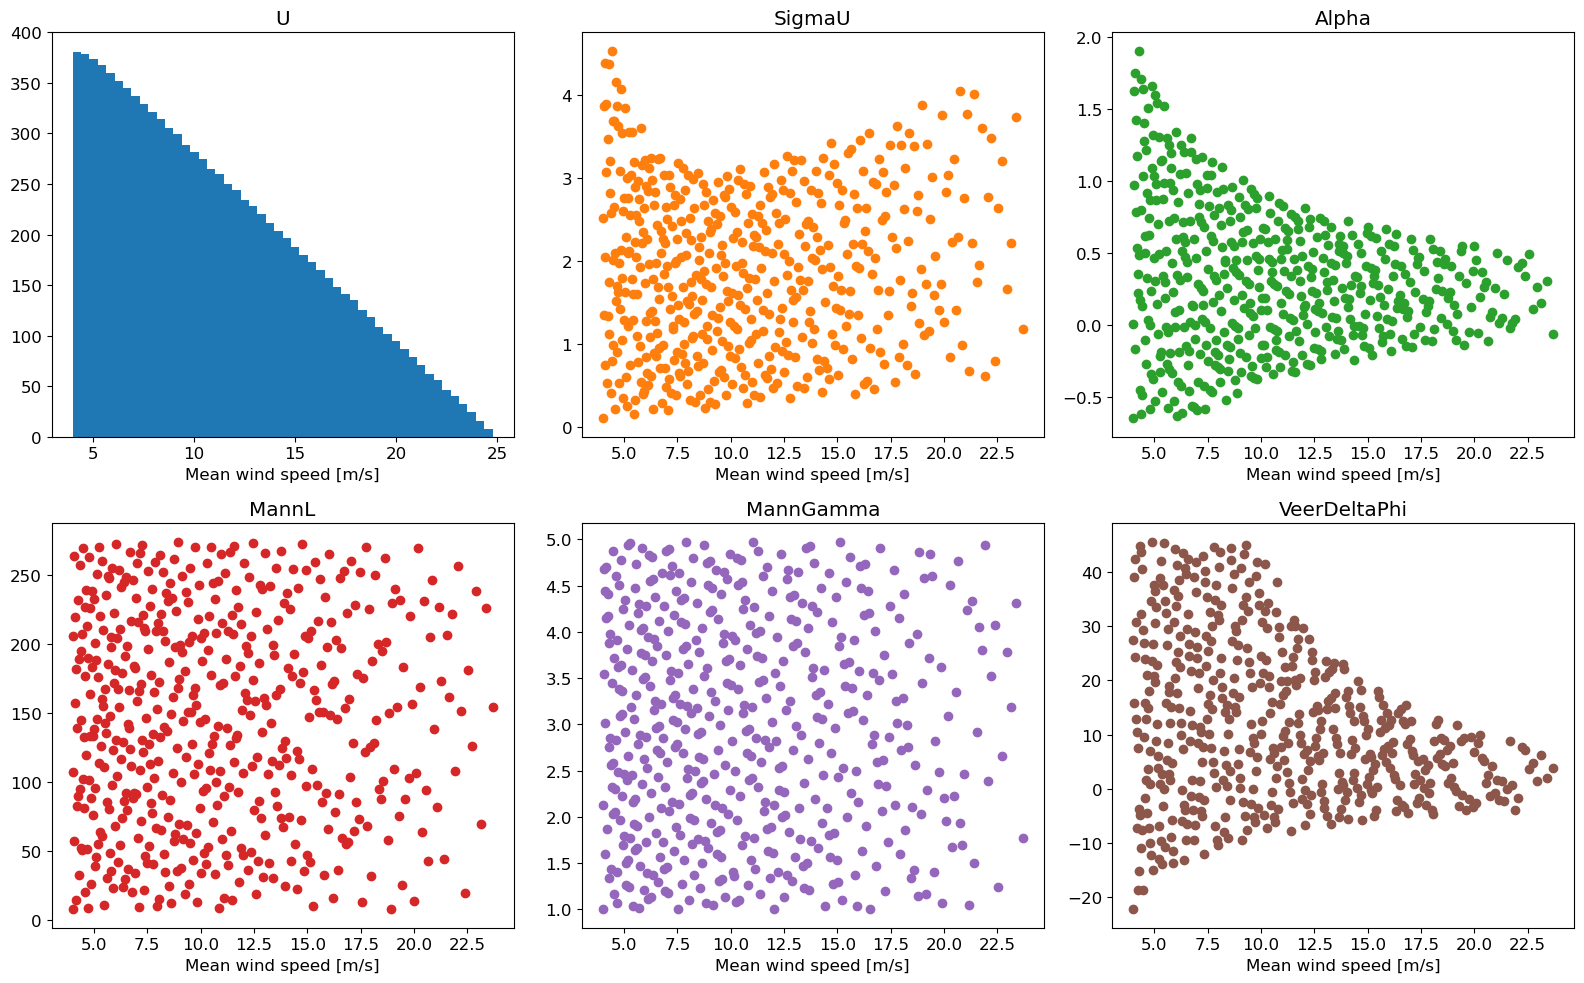

In [25]:
import matplotlib.pyplot as plt
nplotpoints = 500
plt.rc('font', size=12) 
fig1,axs1 = plt.subplots(2,3,figsize = (16,10))
plt.setp(axs1,xlabel = "Mean wind speed [m/s]")
plt.setp(axs1[0,0], title = FeatureNames[0])
plt.setp(axs1[0,1], title = FeatureNames[1])
plt.setp(axs1[0,2], title = FeatureNames[2])
plt.setp(axs1[1,0], title = FeatureNames[3])
plt.setp(axs1[1,1], title = FeatureNames[4])
plt.setp(axs1[1,2], title = FeatureNames[5])
axs1[0,0].hist(AllInputData.iloc[:,0],50,color = 'C0')
axs1[0,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,1],'o',color = 'C1')
axs1[0,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,2],'o',color = 'C2')
axs1[1,0].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,3],'o',color = 'C3')
axs1[1,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,4],'o',color = 'C4')
axs1[1,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,5],'o',color = 'C5')
plt.tight_layout()             
plt.show()

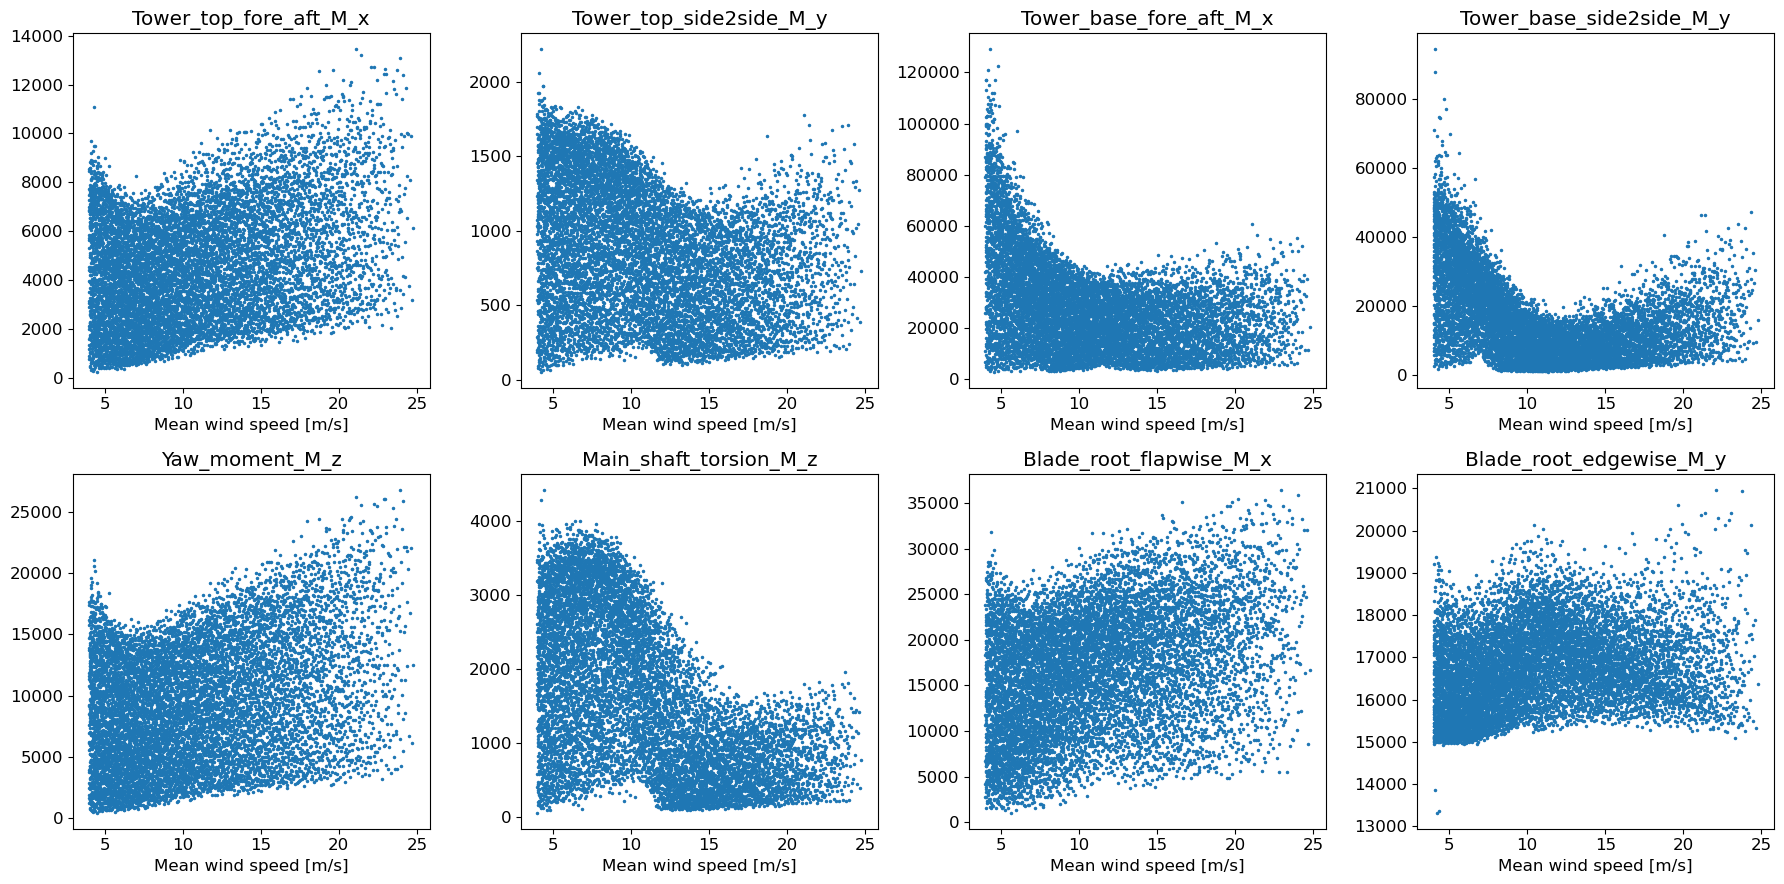

In [26]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Mean wind speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

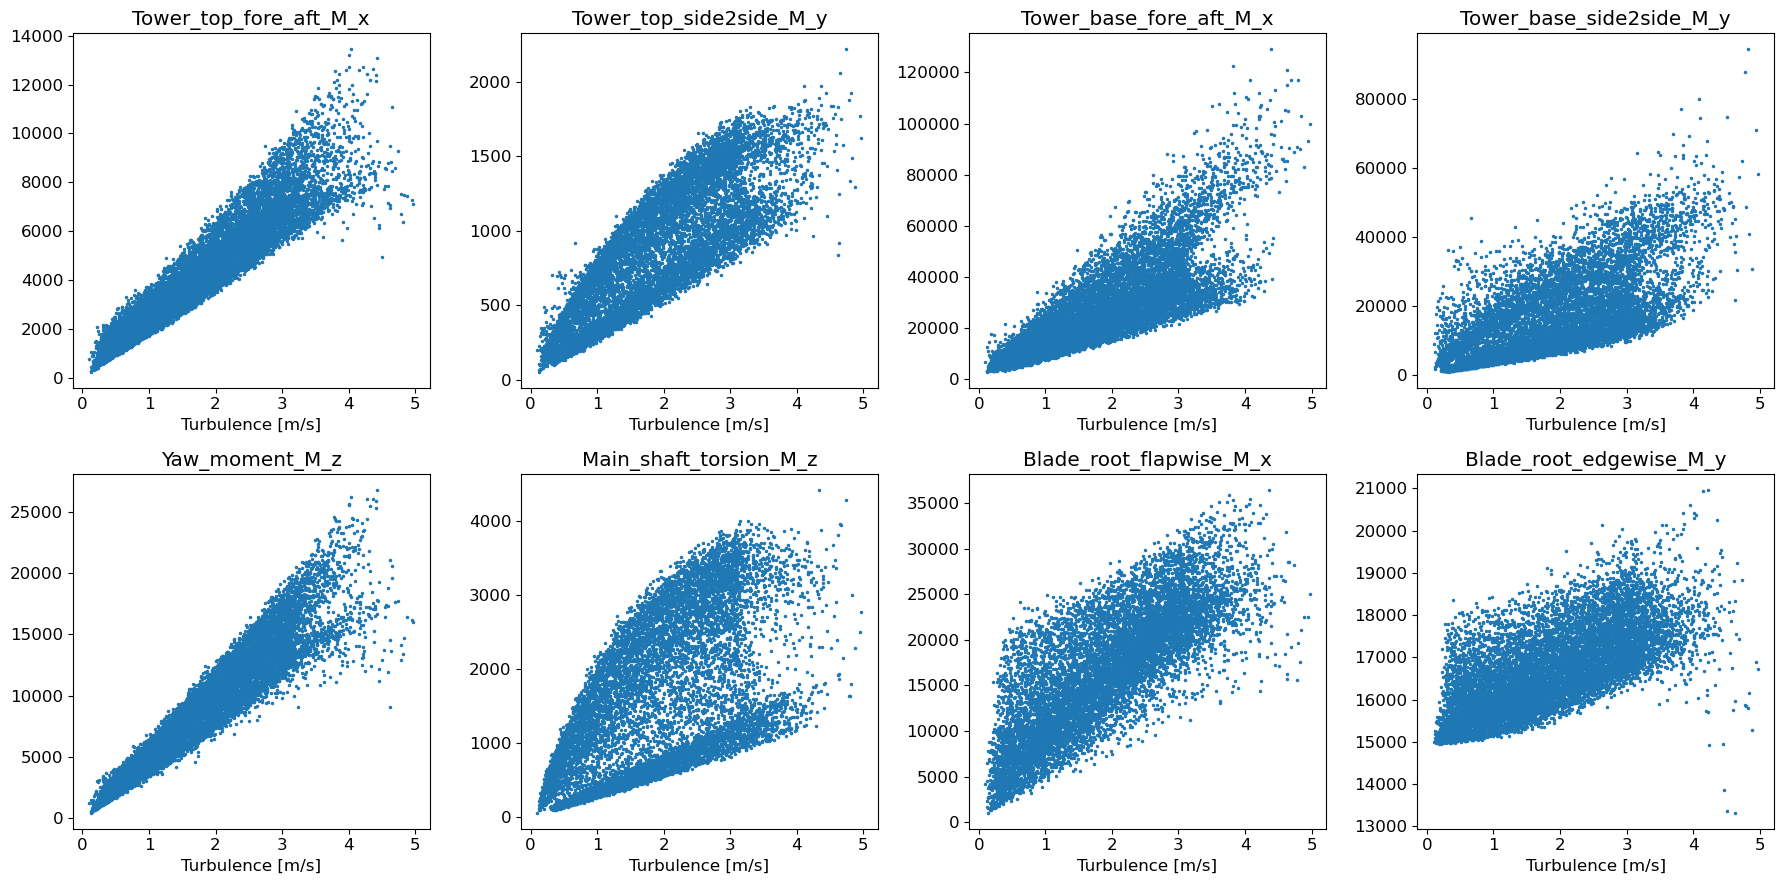

In [27]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

In [28]:
# Building a design matrix for a polynomial of 3rd order
def DesignMatrixO3(X):
    ndim = X.shape[1] 
    npoints = X.shape[0]
    m = int(((ndim-1)/2)*ndim)
    Xmatrix = np.zeros((npoints,3*ndim + 3*m + 1))
    columncount = 0
    Xmatrix[:,columncount] = np.ones(npoints)
    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]

    for i in range(ndim -1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*X[:,j]

    for i in range(ndim):
        columncount+= 1
        Xmatrix[:,columncount] = X[:,i]**2

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = (X[:,i]**2)*X[:,j]

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*(X[:,j]**2)

    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]**3
    return Xmatrix


def PredictPolyO3(X,Alsq):
    Xmatrix = DesignMatrixO3(X)
    Y = np.dot(Xmatrix,Alsq)
    return Y


def GetPredictedData(AllTargetData, Xmatrix):
    
    Y_Mx_pred = {}
    
    # print(AllTargetData.columns.values)
    for icol,col in enumerate(AllTargetData.columns.values):
    
        Y_Mx = AllTargetData['Tower_base_fore_aft_M_x']
        Y_Mx = AllTargetData[f'{col}']

        # Determine beta
        XX = np.dot(Xmatrix.T, Xmatrix)
        XY = np.dot(Xmatrix.T, Y_Mx)
        beta = np.linalg.lstsq(XX, XY, rcond=None)
        beta = beta[0]

        # Calculate predicted data and store      
        Y_Mx_pred[f'{col}'] = np.dot(Xmatrix, beta)
    
    # Create a dataframe with all the predicted data     
    AllPredData = pd.DataFrame(Y_Mx_pred)
    
    return AllPredData

In [29]:
# Construct coefficient matrix (Xmatrix)
Xmatrix = DesignMatrixO3(AllInputData.values)

AllPredData = GetPredictedData(AllTargetData, Xmatrix)

AllPredData.head()

Tower_top_fore_aft_M_x  Tower_top_side2side_M_y  Tower_base_fore_aft_M_x  \
0              308.279244               -97.223302             12397.437749   
1             3351.150153               430.334736             16779.879361   
2             4811.696291              1136.424072             39042.521403   
3             2315.940235               202.668998              8178.223004   
4             3403.816160              1094.917077             33951.597781   

   Tower_base_side2side_M_y  Yaw_moment_M_z  Main_shaft_torsion_M_z  \
0               9828.604369       -7.656643             -503.577253   
1               8829.962071     6542.849633              528.929613   
2              22191.695968    10124.478141             2376.801697   
3               2427.115021     4224.766208              145.234010   
4              23729.542062     7124.026092             2479.960337   

   Blade_root_flapwise_M_x  Blade_root_edgewise_M_y  
0             -2076.034206              6847.463764  
1              8574.372649             13246.200501  
2             14468.532027             15577.598144  
3             12274.375117             16618.749676  
4             14686.483907             16451.405377

### Dependence vs mean wind speed

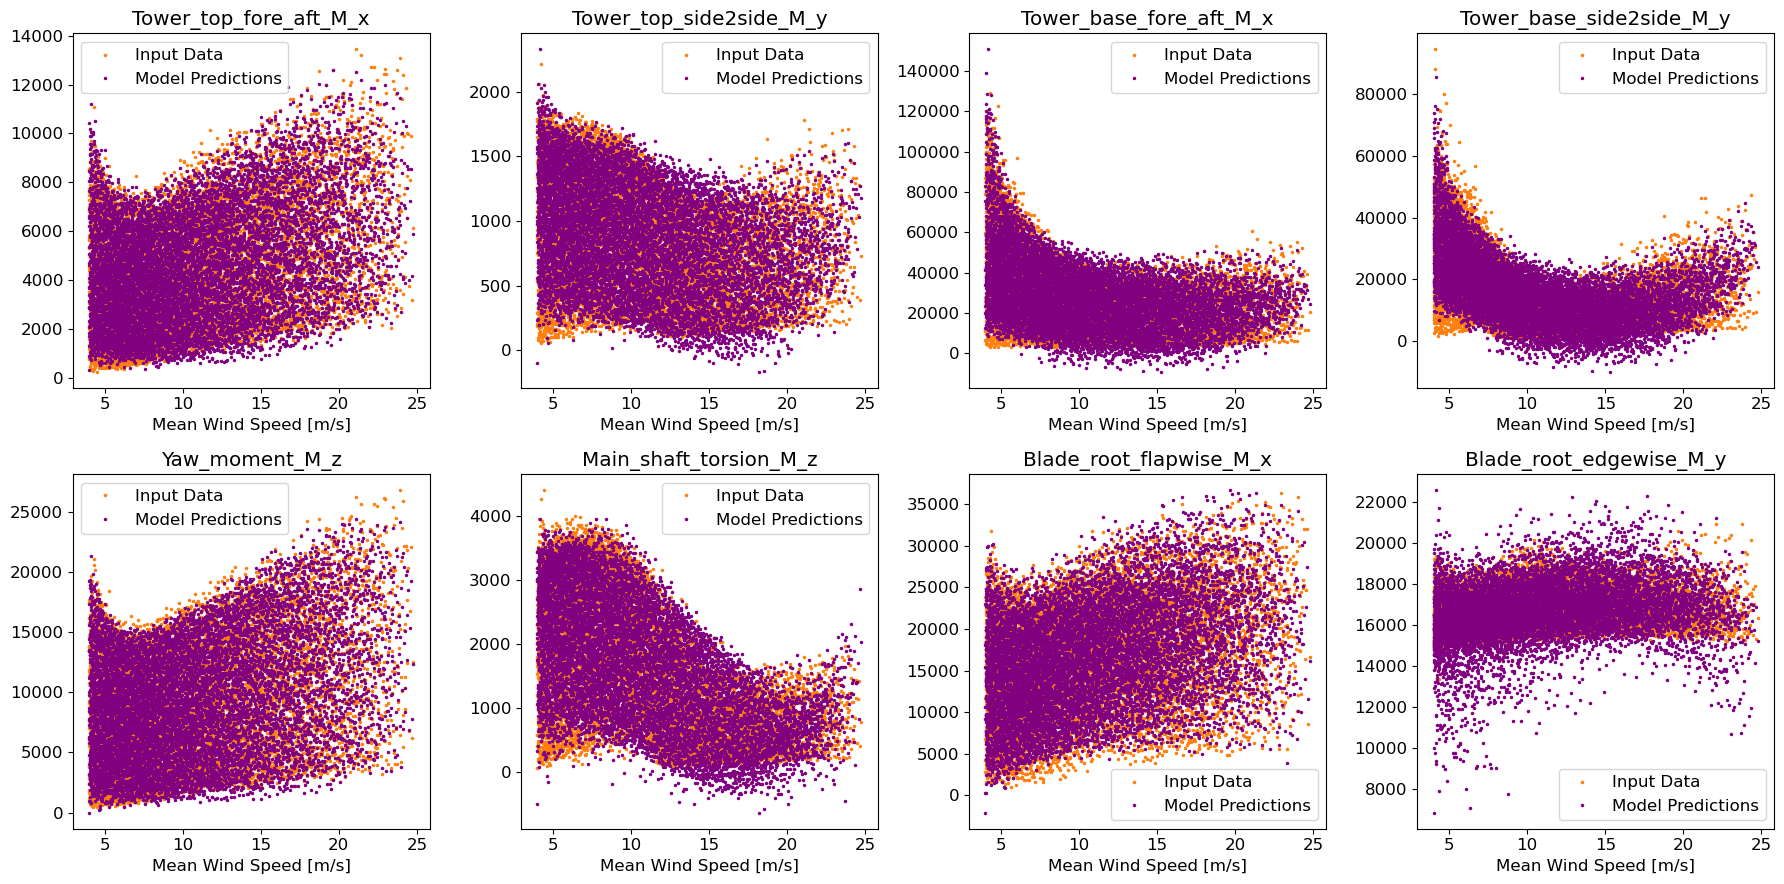

In [30]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.U,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.legend(['Input Data', 'Model Predictions'])
    plt.xlabel('Mean Wind Speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_MWS.pdf')
plt.show()
    

### Dependence vs Turbulence ($\sigma_U$)

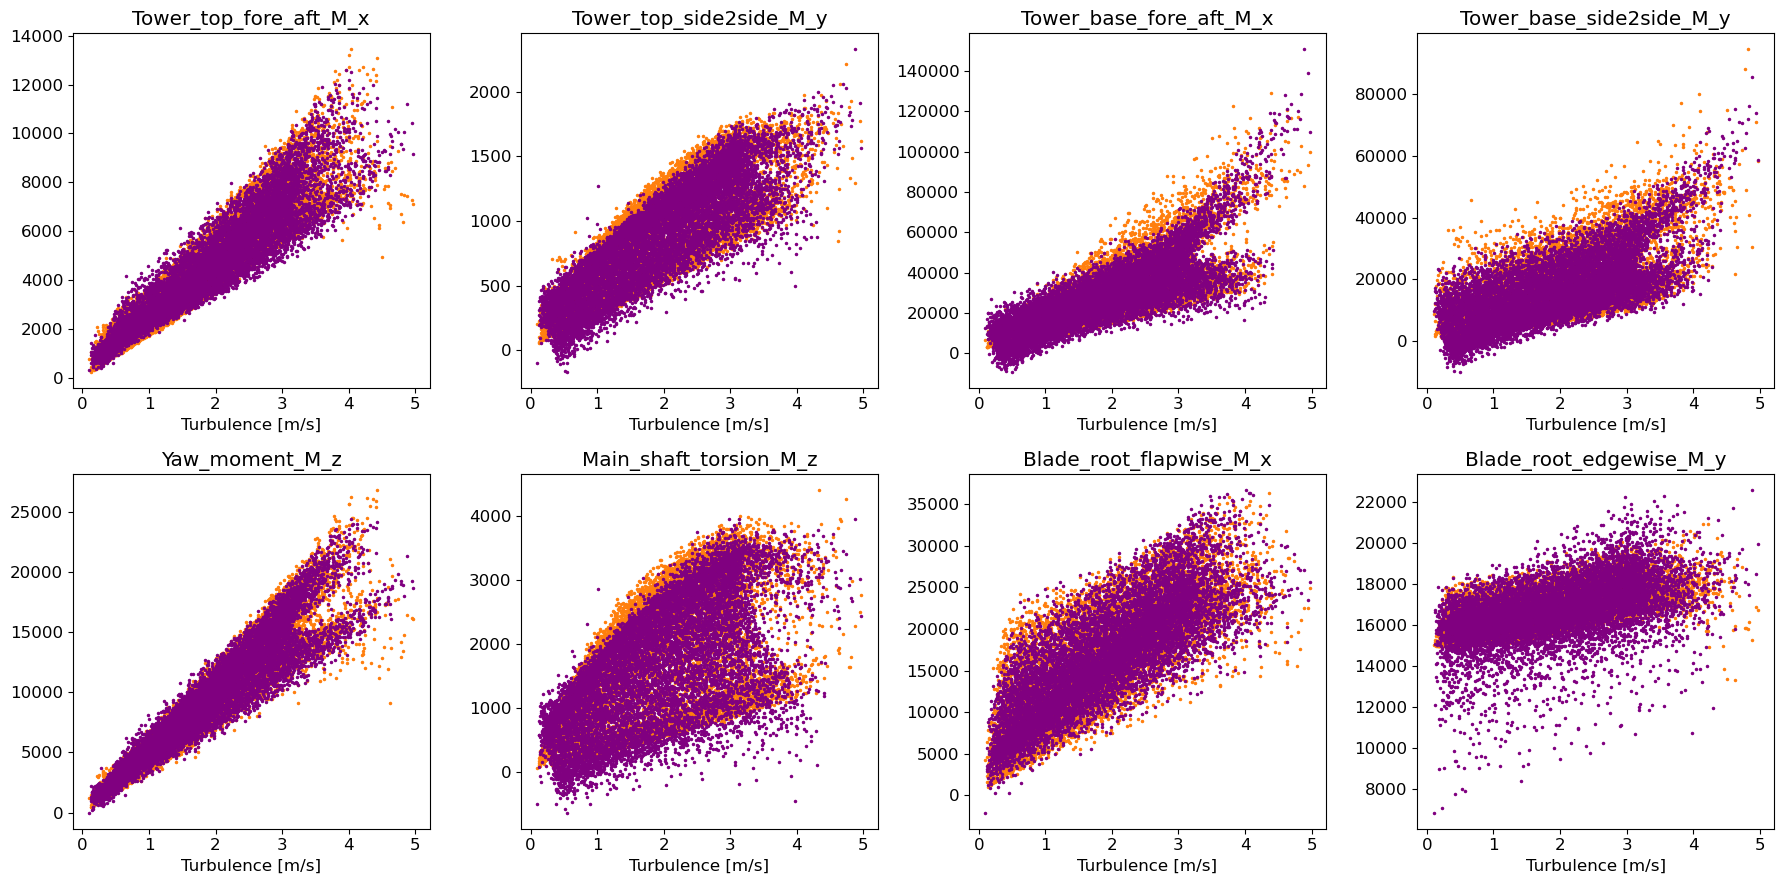

In [31]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.SigmaU,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_SigmaU.pdf')
plt.show()

### Dependence vs shear exponent ($\alpha$)

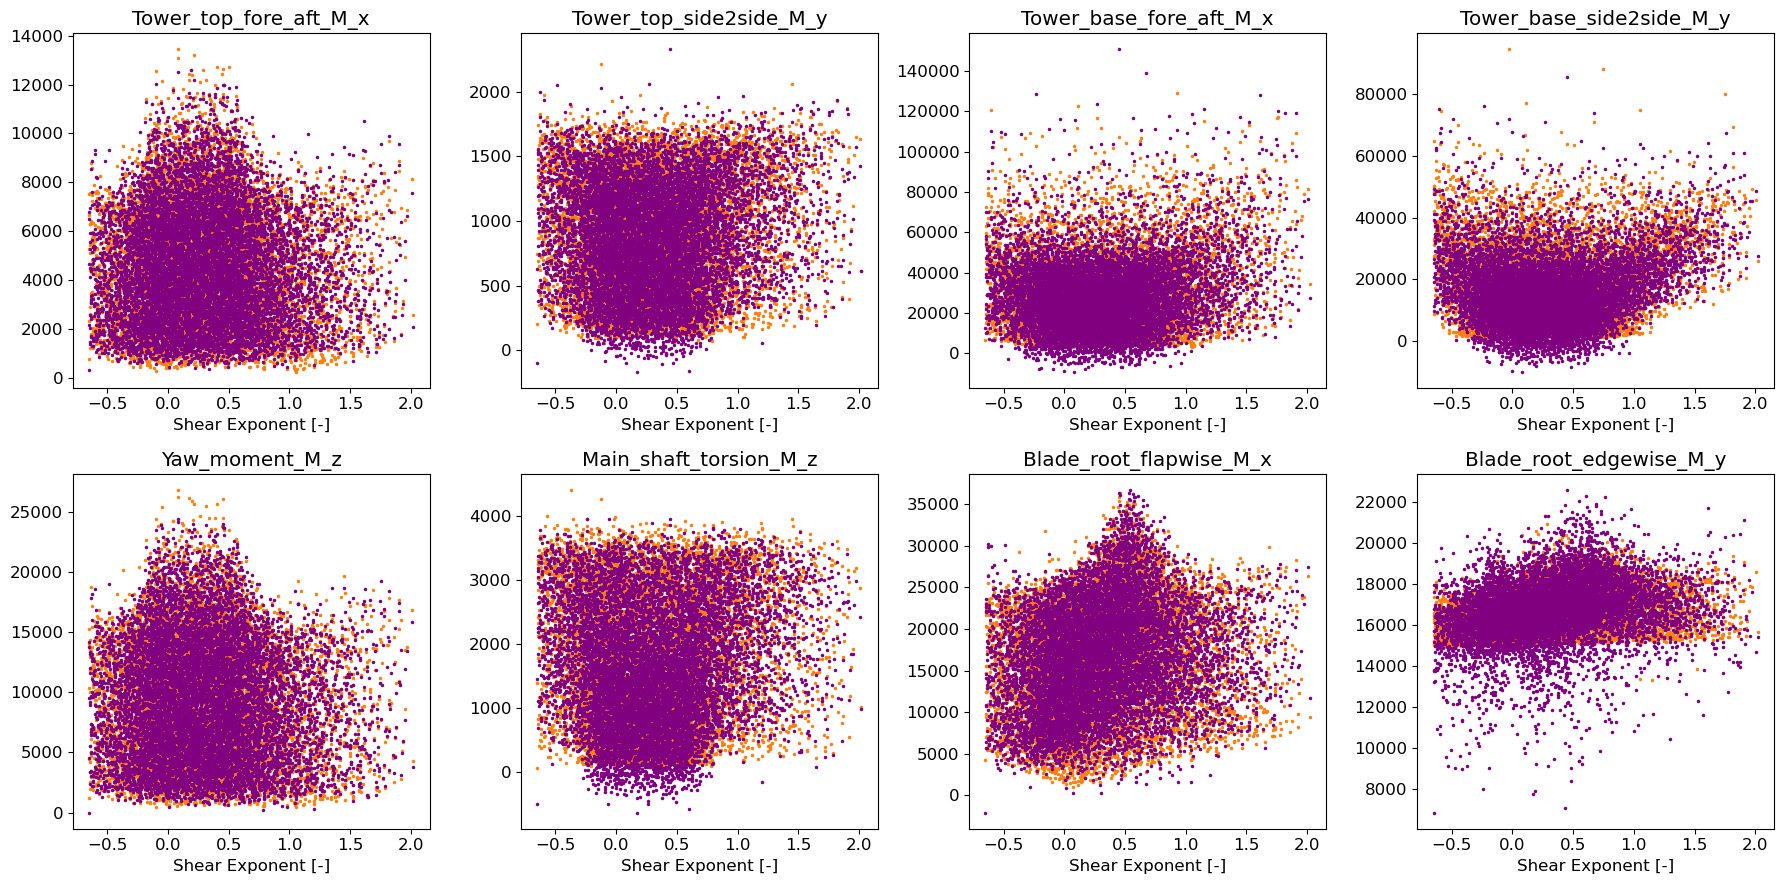

In [32]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.Alpha,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.Alpha,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Shear Exponent [-]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
# plt.savefig(results_path + 'task3/task3_Shearexp.pdf')
plt.show()

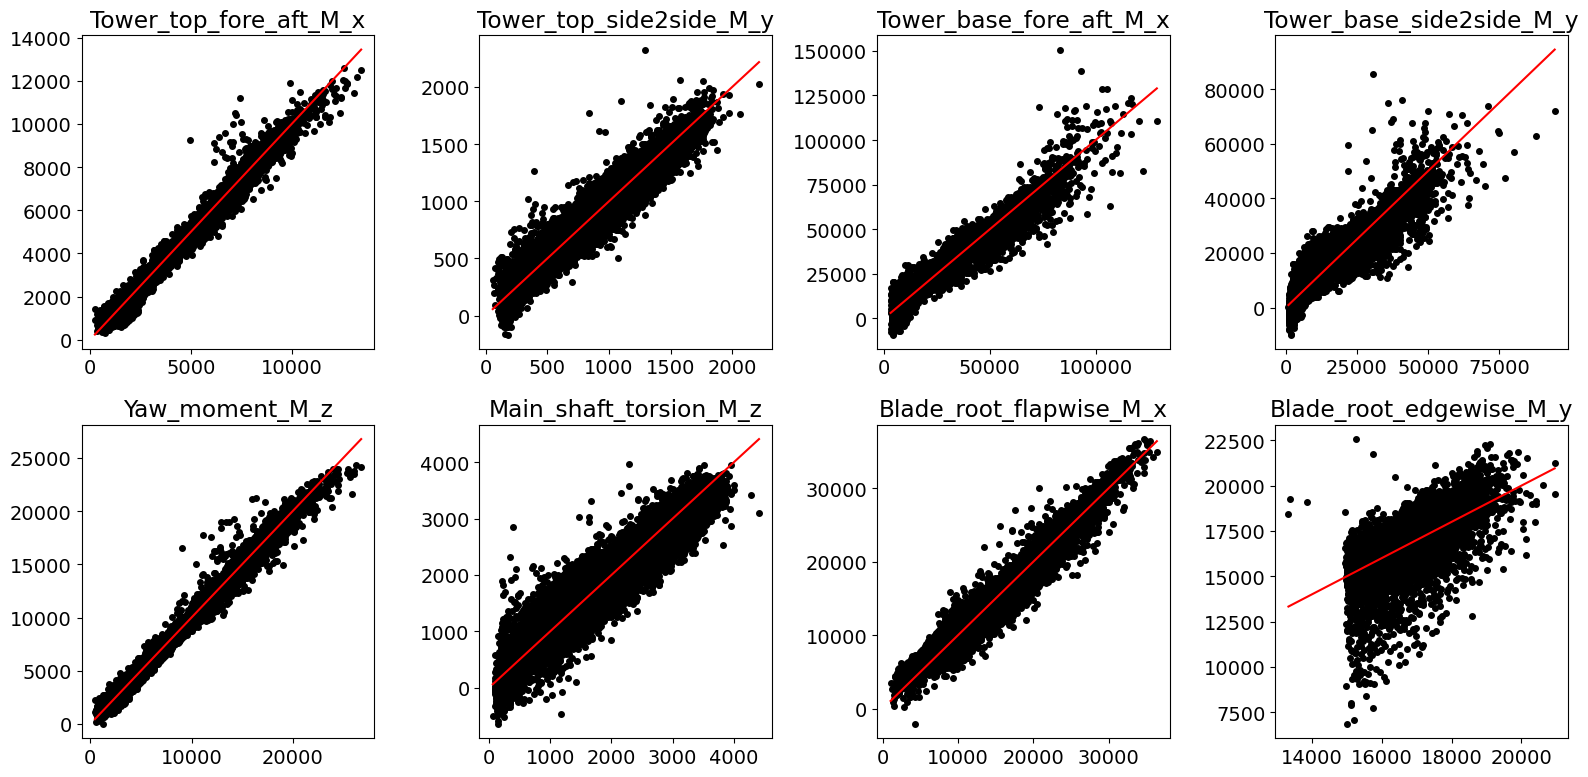

In [33]:
plt.rc('font', size=14) 
fig2a,axs2a = plt.subplots(2,4,figsize = (16,8))

for icol,col in enumerate(AllPredData):
    if icol <= 3:
        row=0
    else:
        row=1
        icol = icol-4
        
    axs2a[row,icol].plot(AllTargetData[f'{col}'],AllPredData[f'{col}'],'ok',markersize = 4)
    axs2a[row,icol].plot(np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),\
         np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),'-r')
    axs2a[row,icol].set_title(f"{col}")
    
# axs2a[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()       
# plt.savefig(results_path + 'task3/pp_comparison.png')
plt.show()

In [34]:
for icol,col in enumerate(AllPredData):
    
    Rsq_poly = (np.corrcoef(AllTargetData[f'{col}'],AllPredData[f'{col}'])[0,1])**2
    RMSE_poly = np.sqrt( np.mean((AllTargetData[f'{col}'] - AllPredData[f'{col}'])**2))
    print(f"\n{col}")
    print('R-square of polynomial model: ' + str(Rsq_poly))
    print('RMSE of polynomial model: ' + str(RMSE_poly))


Tower_top_fore_aft_M_x
R-square of polynomial model: 0.9780605803653517
RMSE of polynomial model: 3271.1289477554565

Tower_top_side2side_M_y
R-square of polynomial model: 0.9165190256180117
RMSE of polynomial model: 598.8302471806389

Tower_base_fore_aft_M_x
R-square of polynomial model: 0.9188414862680923
RMSE of polynomial model: 24848.191330276037

Tower_base_side2side_M_y
R-square of polynomial model: 0.8325495750033188
RMSE of polynomial model: 15897.051573457617

Yaw_moment_M_z
R-square of polynomial model: 0.9840149179660981
RMSE of polynomial model: 6999.345343859783

Main_shaft_torsion_M_z
R-square of polynomial model: 0.8852992873020286
RMSE of polynomial model: 1374.5553396731889

Blade_root_flapwise_M_x
R-square of polynomial model: 0.9438143344594305
RMSE of polynomial model: 9413.054657845498

Blade_root_edgewise_M_y
R-square of polynomial model: 0.43276236371233784
RMSE of polynomial model: 1787.112933731214


In [35]:
# Obtaining the total blade root moment 
AllTargetData["Blade_root_tot"] = np.sqrt(AllTargetData["Blade_root_flapwise_M_x"]**2 + AllTargetData["Blade_root_edgewise_M_y"]**2)
AllTargetData

Tower_top_fore_aft_M_x  Tower_top_side2side_M_y  \
PointNo                                                    
1                    747.561872               200.666288   
2                   3556.031457               676.339081   
3                   4667.540374              1337.390736   
4                   2468.757942               242.431345   
5                   3261.845253              1035.420007   
...                         ...                      ...   
9996                6564.464434               858.778565   
9997                2047.344061               385.287048   
9998                5958.074303               646.040924   
9999                6631.147297              1463.861197   
10000               2496.414854               257.615064   

         Tower_base_fore_aft_M_x  Tower_base_side2side_M_y  Yaw_moment_M_z  \
PointNo                                                                      
1                    6708.717789               8861.885588     1229.076579   
2                   16692.647572               6329.099515     6952.985180   
3                   47357.937376              31829.036012    10138.140146   
4                    8130.594535               3871.907737     4216.051060   
5                   36971.924749              26395.063750     6630.640795   
...                          ...                       ...             ...   
9996                28091.651088              13608.101268    14513.682848   
9997                22144.619831              16663.888804     3024.747490   
9998                20715.173212               7395.479028    11789.005321   
9999                42145.162750              21430.048990    15017.124218   
10000                8521.878700               5921.710246     4404.835391   

         Main_shaft_torsion_M_z  Blade_root_flapwise_M_x  \
PointNo                                                    
1                     63.457528              4253.317748   
2                   1354.995442             10409.290476   
3                   2804.304402             13755.148891   
4                    250.684887             12307.312889   
5                   2256.349794             13128.763279   
...                         ...                      ...   
9996                1147.107370             21518.552601   
9997                 676.705869              3891.227781   
9998                 740.922800             19334.780023   
9999                3076.452821             24014.999552   
10000                293.419113             23494.461911   

         Blade_root_edgewise_M_y  Blade_root_tot  
PointNo                                           
1                   15006.726860    15597.838405  
2                   16289.414152    19331.278841  
3                   16535.154243    21508.497085  
4                   16500.098901    20584.538234  
5                   16207.306417    20857.641442  
...                          ...             ...  
9996                16773.394758    27283.600895  
9997                15376.750042    15861.465742  
9998                17384.510924    26001.056491  
9999                18408.246843    30258.614564  
10000               16113.811373    28489.377976  

[9980 rows x 9 columns]

### Fitting an neural network model

In [36]:
import sklearn
import sklearn.neural_network

In [37]:
# Initialise neural network model (regressor) object
ANNmodel = sklearn.neural_network.MLPRegressor()

ANNmodel.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [38]:
# Trying with tanh activation
ANNmodel.set_params(hidden_layer_sizes=(12,12), activation='tanh', verbose = True )
ANNmodel.fit(AllInputData.values, AllTargetData["Blade_root_tot"])

Iteration 1, loss = 302054487.37168187
Iteration 2, loss = 301992054.47175384
Iteration 3, loss = 301945108.17926282
Iteration 4, loss = 301913255.78057891
Iteration 5, loss = 301888389.56155390
Iteration 6, loss = 301866833.84565967
Iteration 7, loss = 301846925.58811724
Iteration 8, loss = 301828025.63016498
Iteration 9, loss = 301809766.37630498
Iteration 10, loss = 301791963.43185872
Iteration 11, loss = 301774499.81608820
Iteration 12, loss = 301757285.60834199
Iteration 13, loss = 301740275.25772220
Iteration 14, loss = 301723432.57953799
Iteration 15, loss = 301706717.41708475
Iteration 16, loss = 301690123.30157179
Iteration 17, loss = 301673618.95553750
Iteration 18, loss = 301657193.65033501
Iteration 19, loss = 301640845.56211782
Iteration 20, loss = 301624555.96949035
Iteration 21, loss = 301608324.56579423
Iteration 22, loss = 301592142.04691356
Iteration 23, loss = 301576003.72072107
Iteration 24, loss = 301559903.63933045
Iteration 25, loss = 301543840.73630047
Iteration

C:\Users\modes\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(12, 12), verbose=True)

In [39]:
ANNmodel.score(AllInputData, AllTargetData["Blade_root_tot"])

C:\Users\modes\Anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


-22.159989404842737

In [40]:
# Trying with relu activation
ANNmodel.set_params(activation='relu')
ANNmodel.fit(AllInputData.values, AllTargetData["Blade_root_tot"])
print('Model r-square with full data set: ' + str(ANNmodel.score(AllInputData,AllTargetData['Blade_root_tot'])))

Iteration 1, loss = 301664868.60720098
Iteration 2, loss = 300980675.30905324
Iteration 3, loss = 299753556.68267435
Iteration 4, loss = 297114972.51958472
Iteration 5, loss = 291991189.11331731
Iteration 6, loss = 282907473.32811397
Iteration 7, loss = 268630048.56489474
Iteration 8, loss = 249417072.75055158
Iteration 9, loss = 226005807.50295082
Iteration 10, loss = 199592111.00027660
Iteration 11, loss = 171730057.36439872
Iteration 12, loss = 144393519.06496784
Iteration 13, loss = 119451724.95054211
Iteration 14, loss = 98367988.68358964
Iteration 15, loss = 81598475.76299608
Iteration 16, loss = 70082911.71432161
Iteration 17, loss = 63057938.67760312
Iteration 18, loss = 59576173.89677590
Iteration 19, loss = 58058324.83495853
Iteration 20, loss = 57313892.85356443
Iteration 21, loss = 56773193.76365402
Iteration 22, loss = 56271035.13775770
Iteration 23, loss = 55763956.18177674
Iteration 24, loss = 55238603.53204439
Iteration 25, loss = 54691491.00416956
Iteration 26, loss = 

C:\Users\modes\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\modes\Anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [41]:
# None of the two activation methods has given converged fit

In [42]:
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(AllInputData)
Yscaler = Yscaler.fit(AllTargetData["Blade_root_tot"].values.reshape(-1,1))


TrainTestRatio = 0.8
N = len(AllInputData)
print(AllInputData.shape)

# Here we take only a subset of the input data, not the entire dataset
Xtrain = Xscaler.transform(AllInputData.values[:int(N*TrainTestRatio),:])
Xtest = Xscaler.transform(AllInputData.values[int(N*TrainTestRatio):,:])

Ytrain = Yscaler.transform(AllTargetData['Blade_root_tot'].values[:int(N*TrainTestRatio)].reshape(-1,1))
Ytest = Yscaler.transform(AllTargetData['Blade_root_tot'].values[int(N*TrainTestRatio):].reshape(-1,1))

print(AllInputData.values)
print(AllInputData.values[:int(N*TrainTestRatio),:])
print(N*TrainTestRatio)
print(Ytrain)

(9980, 6)
[[ 4.00000000e+00  1.00000000e-01 -6.50000000e-01  7.50000000e+00
   1.00000000e+00 -2.22500000e+01]
 [ 1.01507576e+01  1.20865642e+00 -1.39691519e-01  4.84706339e+01
   1.36363636e+00 -4.77121702e+00]
 [ 6.81346652e+00  2.26146310e+00  1.29071159e-01  8.83797099e+01
   1.72727273e+00 -3.98159257e+00]
 ...
 [ 1.33261720e+01  2.04361659e+00  3.45013069e-01  4.66692450e+01
   4.48801311e+00 -6.19744103e+00]
 [ 9.29878160e+00  2.83002980e+00  7.09374276e-01  8.48835307e+01
   4.85164948e+00 -4.45739239e+00]
 [ 1.98982102e+01  6.84805058e-01  5.74861537e-01  1.23097816e+02
   1.24834369e+00 -1.81735203e+00]]
[[ 4.00000000e+00  1.00000000e-01 -6.50000000e-01  7.50000000e+00
   1.00000000e+00 -2.22500000e+01]
 [ 1.01507576e+01  1.20865642e+00 -1.39691519e-01  4.84706339e+01
   1.36363636e+00 -4.77121702e+00]
 [ 6.81346652e+00  2.26146310e+00  1.29071159e-01  8.83797099e+01
   1.72727273e+00 -3.98159257e+00]
 ...
 [ 9.97595921e+00  9.89433895e-01  6.72712732e-01  1.67646665e+02
   1

C:\Users\modes\Anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\modes\Anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [43]:
Ytrain.shape

(7984, 1)

In [44]:
# Make a fit with the transformed data

ANNmodel.set_params(learning_rate_init = 0.01, activation = 'relu',tol = 1e-6,n_iter_no_change = 10, hidden_layer_sizes = (12,12), validation_fraction = 0.1)

ANNmodel.fit(Xtrain, Ytrain.ravel())


Iteration 1, loss = 0.19415422
Iteration 2, loss = 0.03733132
Iteration 3, loss = 0.02555415
Iteration 4, loss = 0.01879778
Iteration 5, loss = 0.01528719
Iteration 6, loss = 0.01316005
Iteration 7, loss = 0.01257457
Iteration 8, loss = 0.01168879
Iteration 9, loss = 0.01133628
Iteration 10, loss = 0.01116232
Iteration 11, loss = 0.01065943
Iteration 12, loss = 0.01014433
Iteration 13, loss = 0.00974545
Iteration 14, loss = 0.00938064
Iteration 15, loss = 0.00949577
Iteration 16, loss = 0.00915429
Iteration 17, loss = 0.00936935
Iteration 18, loss = 0.00867494
Iteration 19, loss = 0.00864816
Iteration 20, loss = 0.00840583
Iteration 21, loss = 0.00850591
Iteration 22, loss = 0.00804919
Iteration 23, loss = 0.00815008
Iteration 24, loss = 0.00794916
Iteration 25, loss = 0.00796012
Iteration 26, loss = 0.00815080
Iteration 27, loss = 0.00758454
Iteration 28, loss = 0.00745076
Iteration 29, loss = 0.00791465
Iteration 30, loss = 0.00770980
Iteration 31, loss = 0.00803214
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(12, 12), learning_rate_init=0.01, tol=1e-06,
             verbose=True)

In [45]:
print( 'Train set r-square: ' + str(ANNmodel.score(Xtrain,Ytrain)))
print( 'Test set r-square: ' + str(ANNmodel.score(Xtest,Ytest)))

Train set r-square: 0.9830561212438248
Test set r-square: 0.9816890536451084


In [46]:
# Compute model predictions for test data
Yout = Yscaler.inverse_transform(ANNmodel.predict(Xtrain).reshape(-1,1))
Yout_test = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1,1))

In [47]:
Yout_test.shape

(1996, 1)

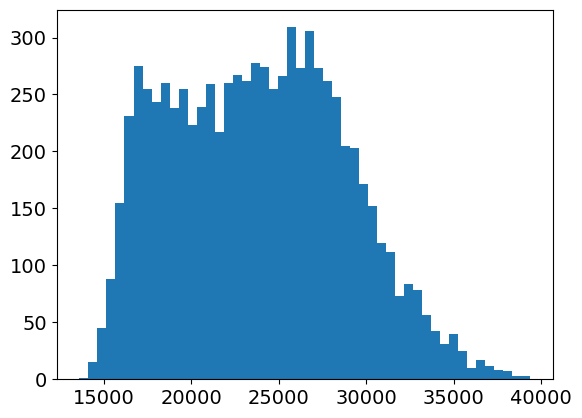

In [48]:
plt.hist(Yout,50)
plt.show()

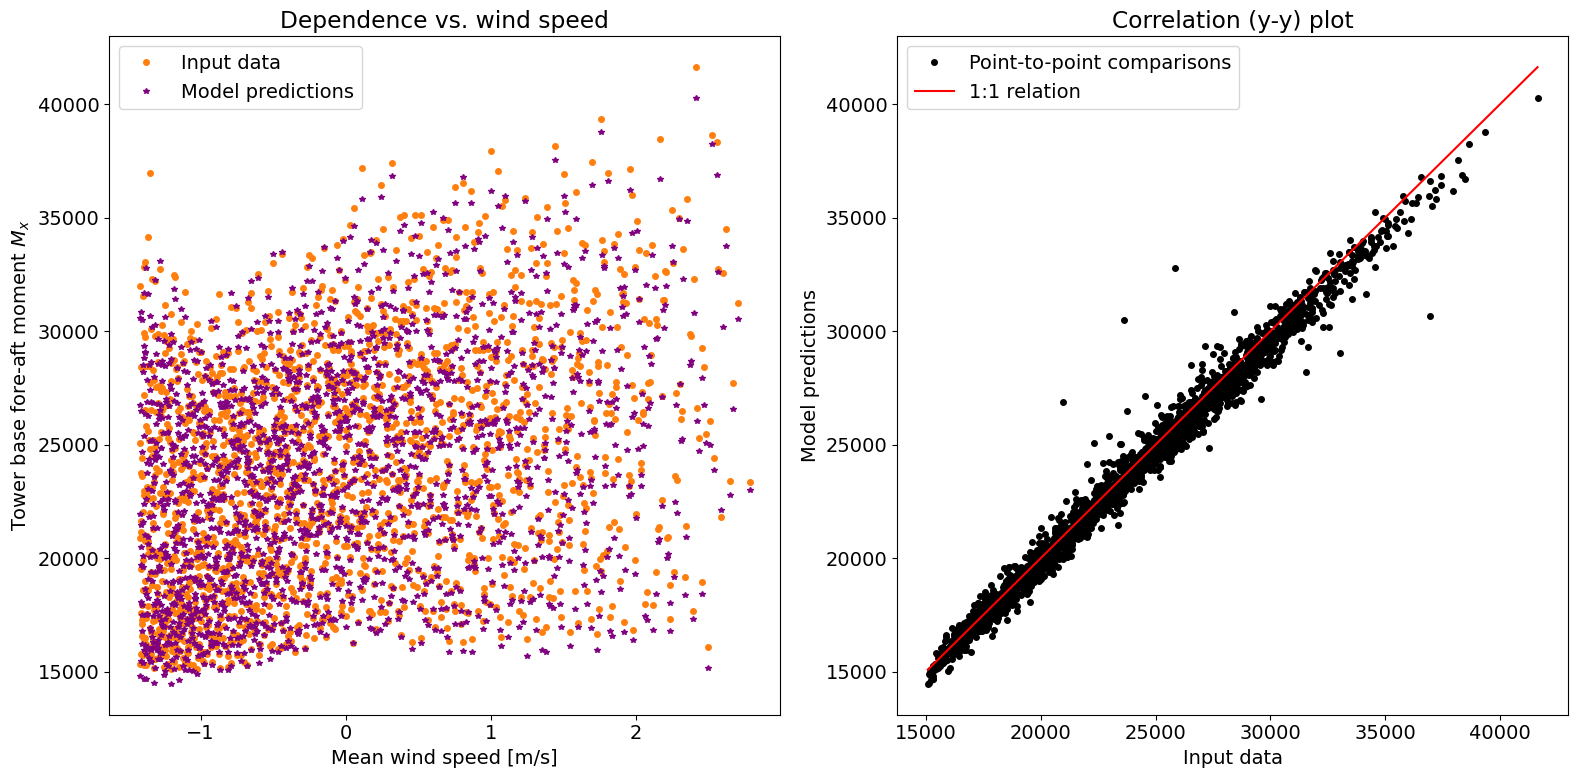

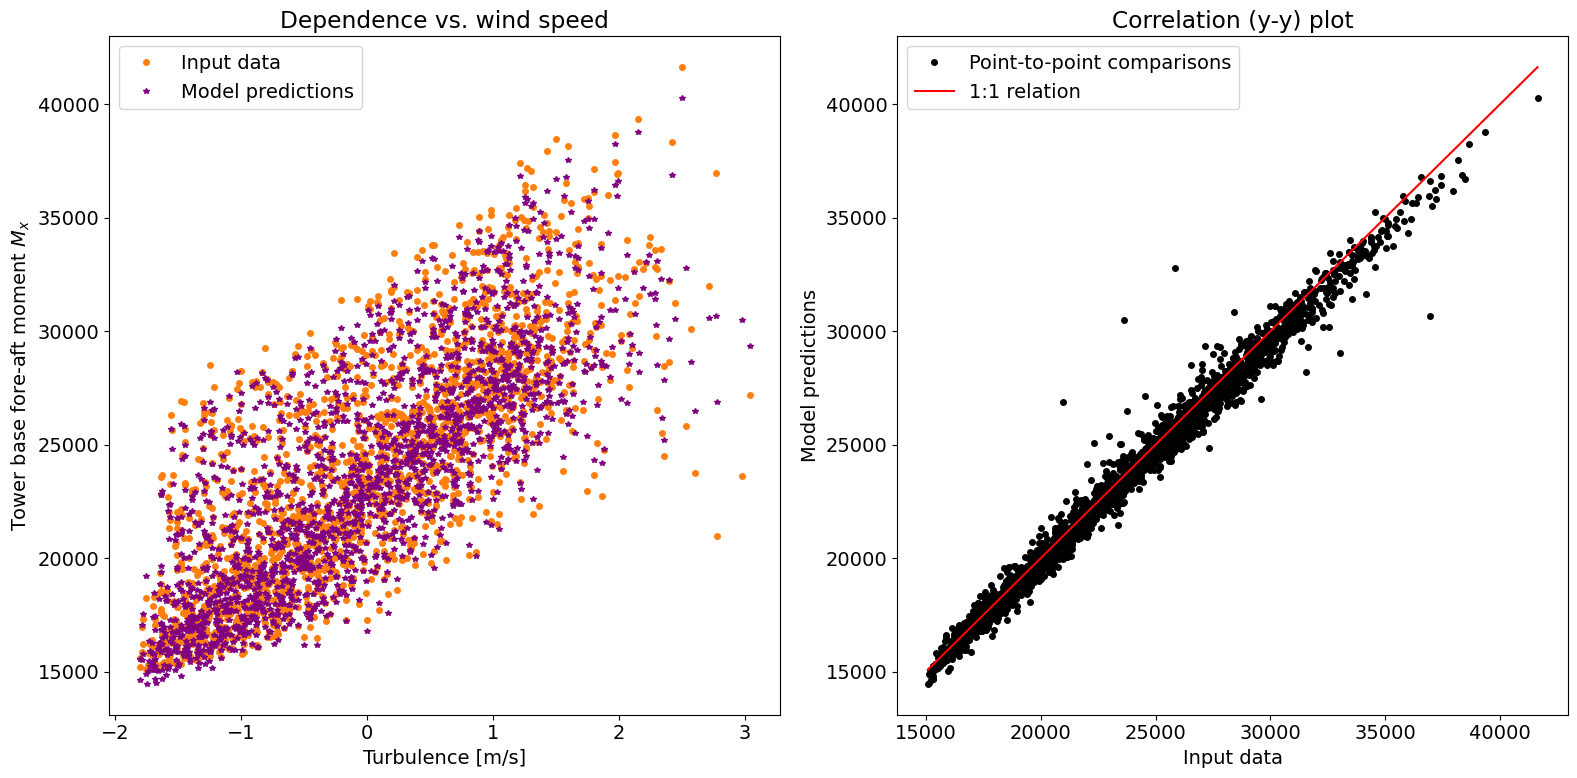

In [166]:
import numpy as np
plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Mean wind speed [m/s]',ylabel = 'Tower base fore-aft moment $M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,0],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,0],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),\
             np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()


plt.rc('font', size=14) 
fig3,axs3 = plt.subplots(1,2,figsize = (16,8))
plt.setp(axs3[0], title = 'Dependence vs. wind speed', xlabel = 'Turbulence [m/s]',ylabel = 'Tower base fore-aft moment $M_x$')
plt.setp(axs3[1], title = 'Correlation (y-y) plot', xlabel = 'Input data',ylabel = 'Model predictions')
axs3[0].plot(Xtest[:,1],Yscaler.inverse_transform(Ytest),'o',markersize = 4,color = 'C1')
axs3[0].plot(Xtest[:,1],Yout_test,'*',markersize = 4,color = 'purple')
axs3[0].legend(['Input data','Model predictions'])
axs3[1].plot(Yscaler.inverse_transform(Ytest),Yout_test,'ok',markersize = 4)
axs3[1].plot(np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),\
             np.array([np.min(AllTargetData['Blade_root_tot']), np.max(AllTargetData['Blade_root_tot'])]),'-r')
axs3[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()             
plt.show()

# Task 4

In [ ]:
u
sigmau
alpha